In [1]:
from src.reader import PoseReader
from src.GlobalOpts import GlobalOpts
from src.classify_single import gen_model
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tensorflow as tf

%matplotlib inline

network_name = 'base'
chkpt_name = 'base'

opts = GlobalOpts(chkpt_name)
opts.model = network_name

network = gen_model(opts)
reader_train = PoseReader('train', opts)
reader_val = PoseReader('valid', opts)

/home/matt/tensorflow/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Generating train reader
Generating valid reader


In [2]:
import tensorflow as tf
network.restore_weights()

In [3]:
with open(join(opts.ARCHLOG_DIR, 'train_data.pkl'), 'rb') as fid:
    data = pickle.load(fid)

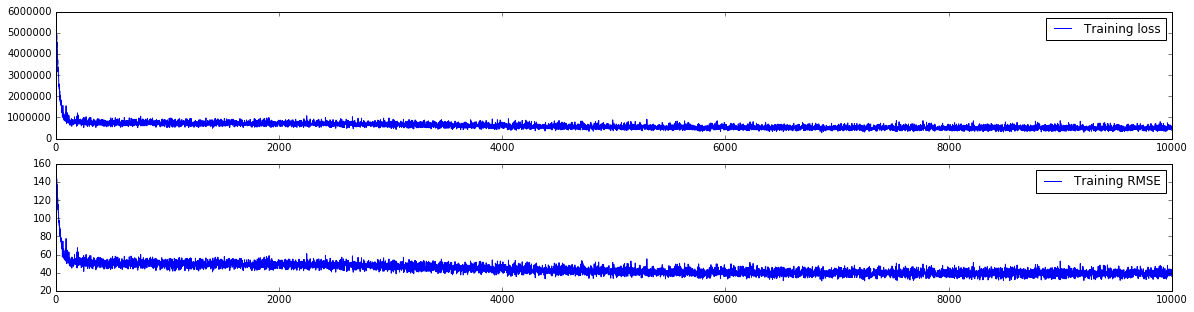

In [4]:
train_hist = data['train_hist']
train_it = [ob[0] for ob in train_hist]
train_loss = [ob[1] for ob in train_hist]
train_rmse = [ob[2] for ob in train_hist]


plt.figure(figsize=(20, 5))
plt.subplot(2,1,1)
plt.plot(train_it, train_loss)
plt.legend(["Training loss"])
plt.subplot(2,1,2)
plt.plot(train_it, train_rmse)
plt.legend(["Training RMSE"])

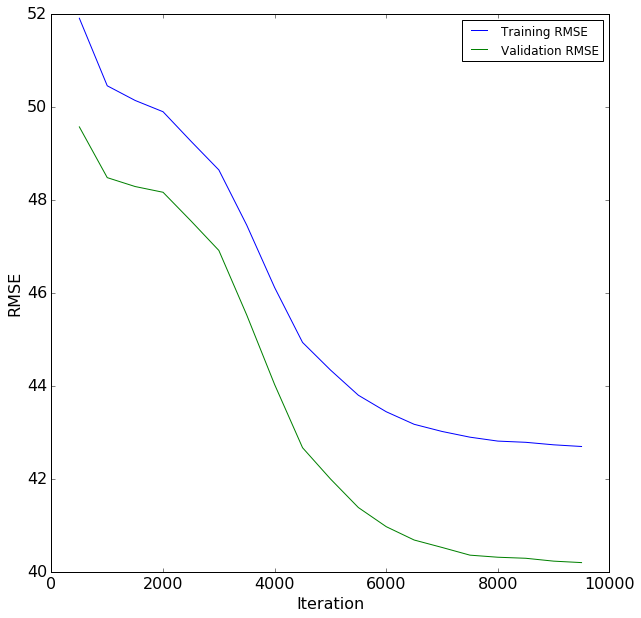

In [9]:
valid_hist = data['valid_hist']
valid_it = [ob[0] for ob in valid_hist]
train_rmse = [ob[1] for ob in valid_hist]
valid_rmse = [ob[2] for ob in valid_hist]

plt.figure(figsize=(10, 10))
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(valid_it, train_rmse)
plt.plot(valid_it, valid_rmse)
plt.legend(["Training RMSE","Validation RMSE"])
plt.savefig('base_loss.png')

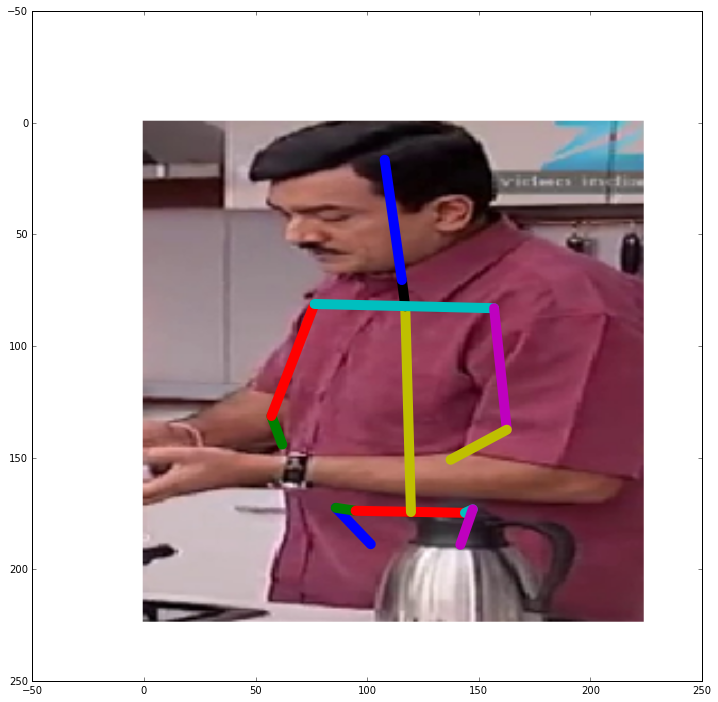

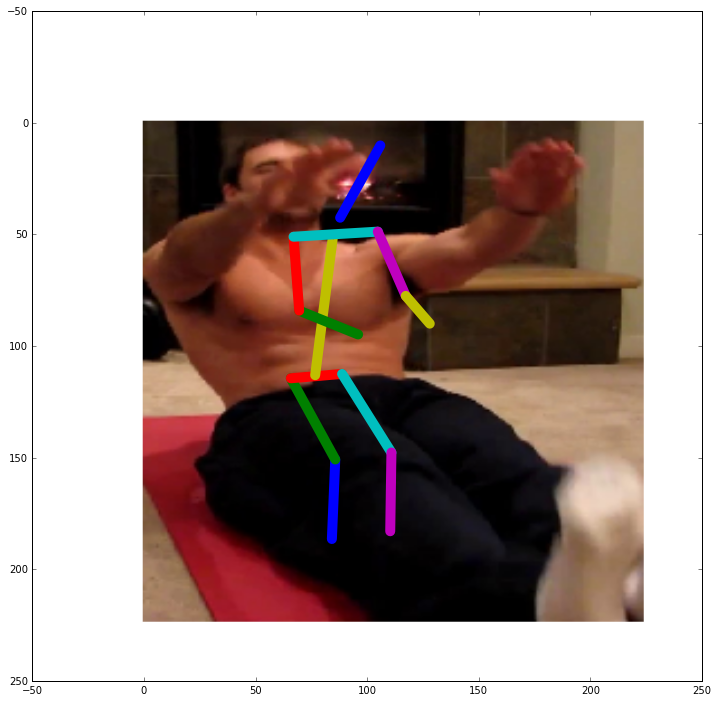

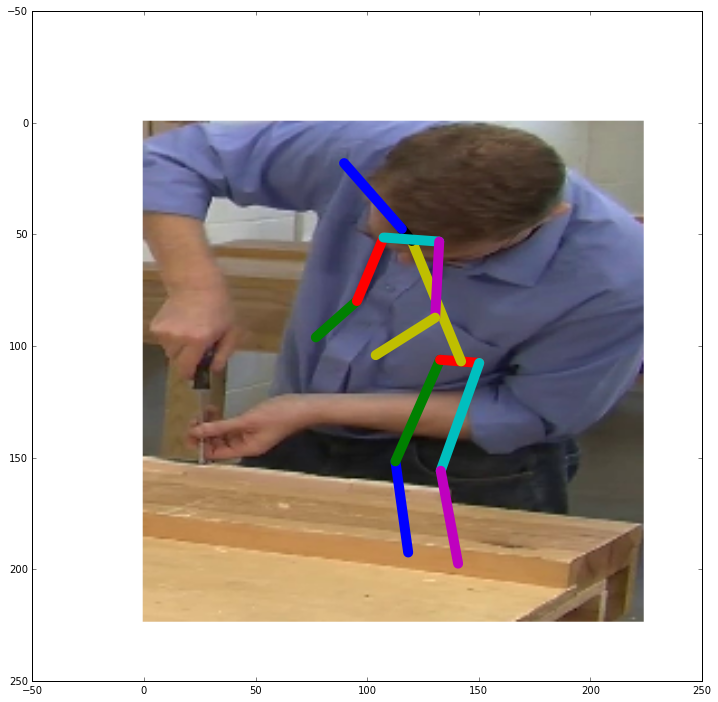

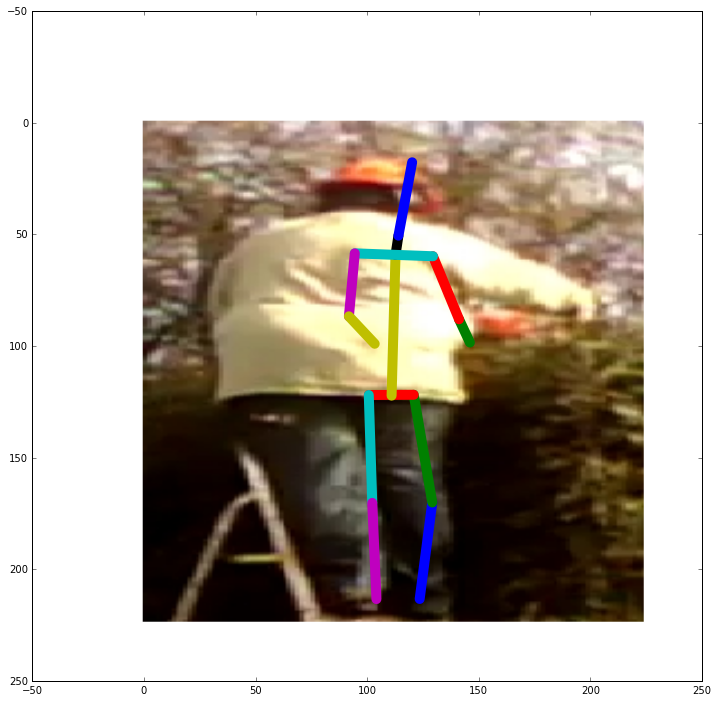

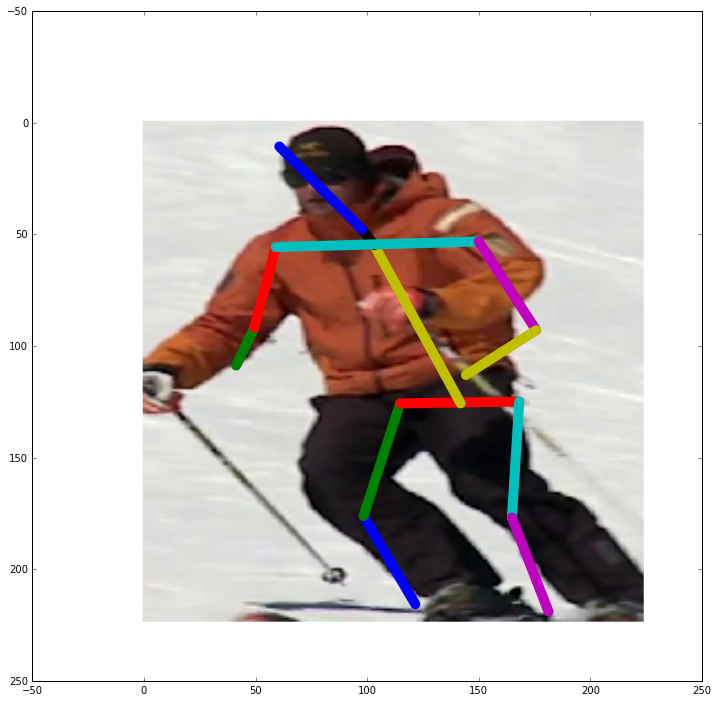

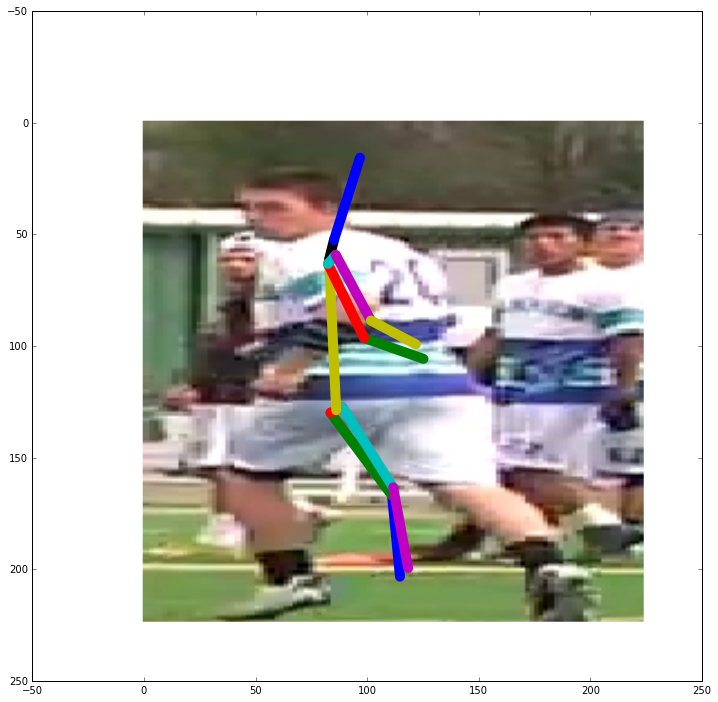

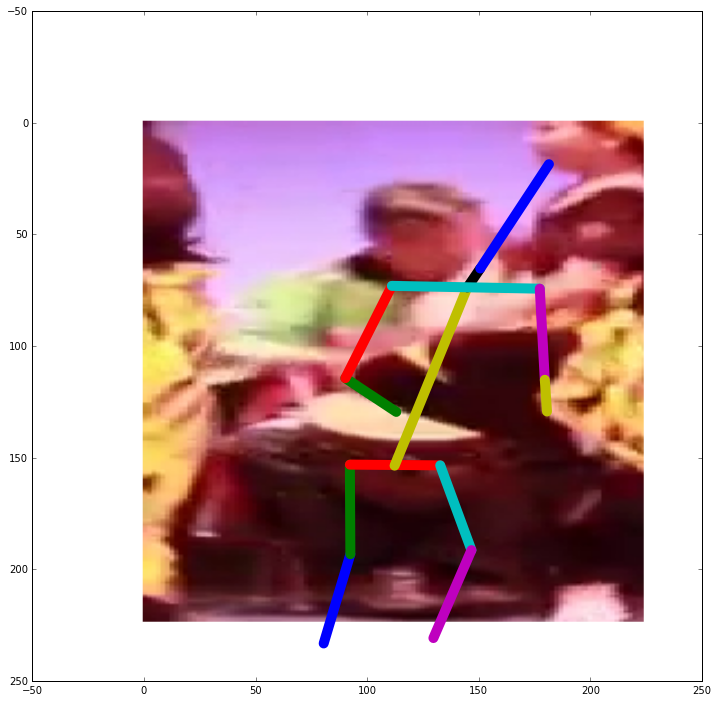

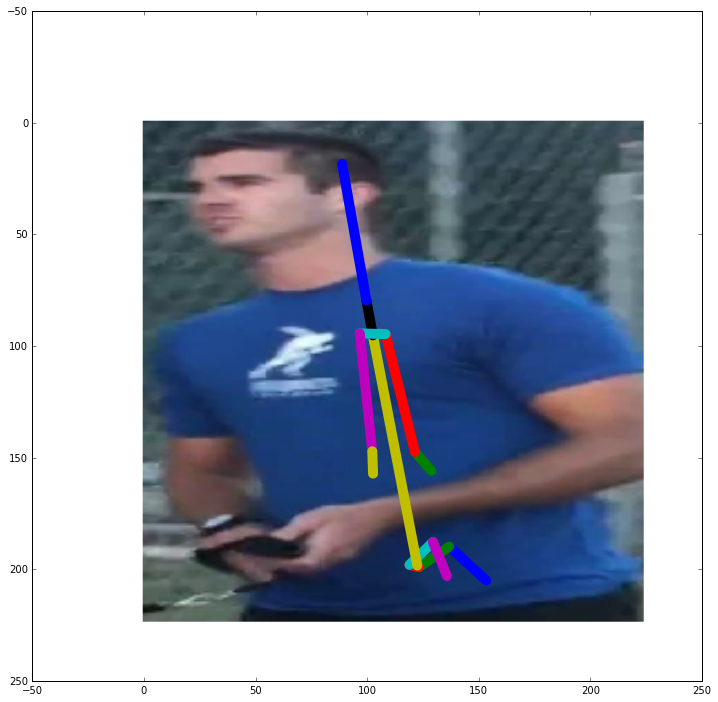

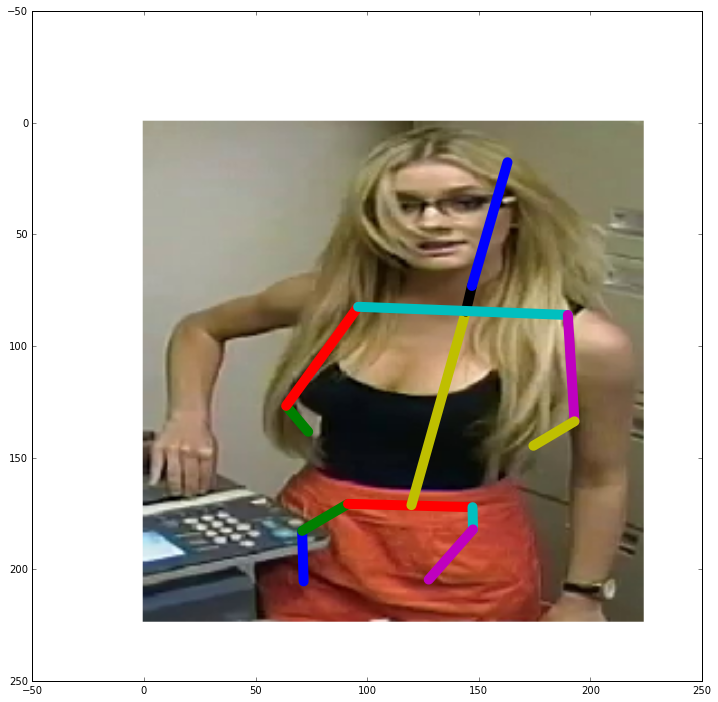

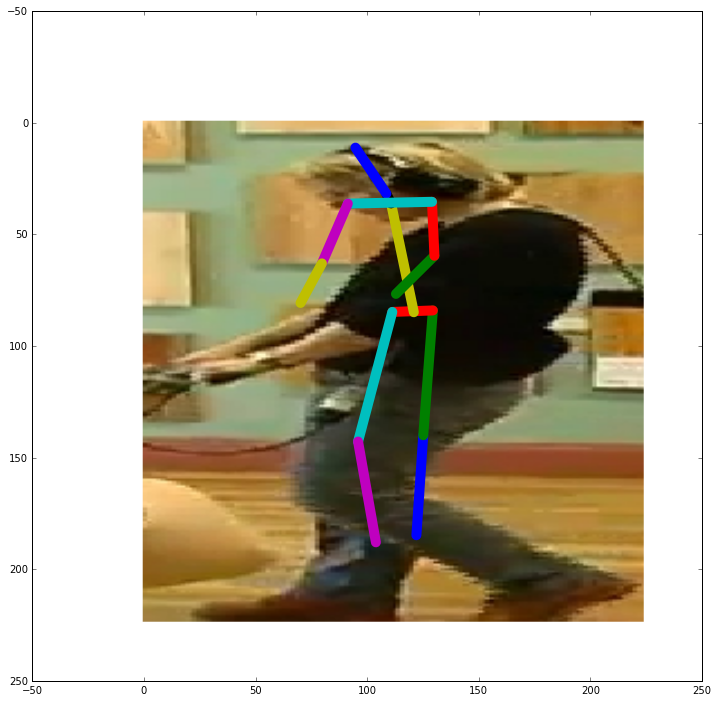

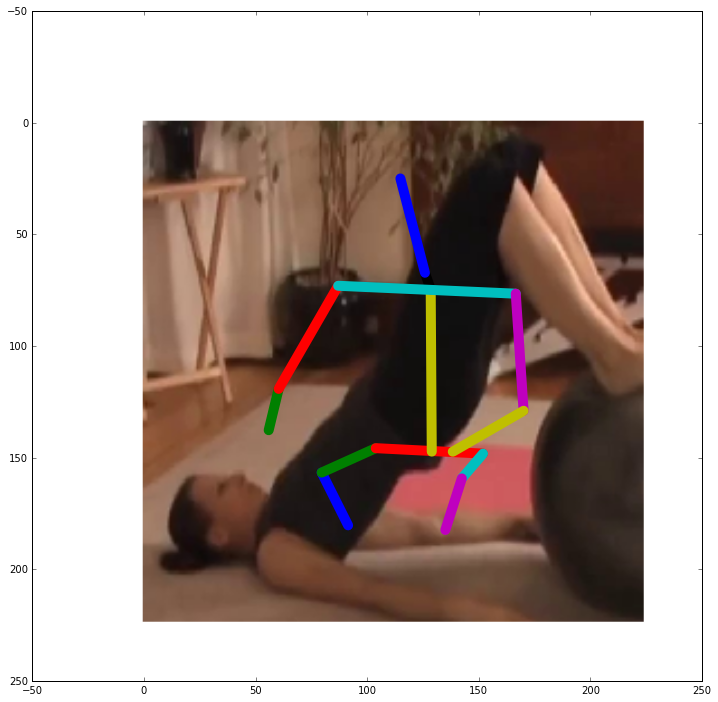

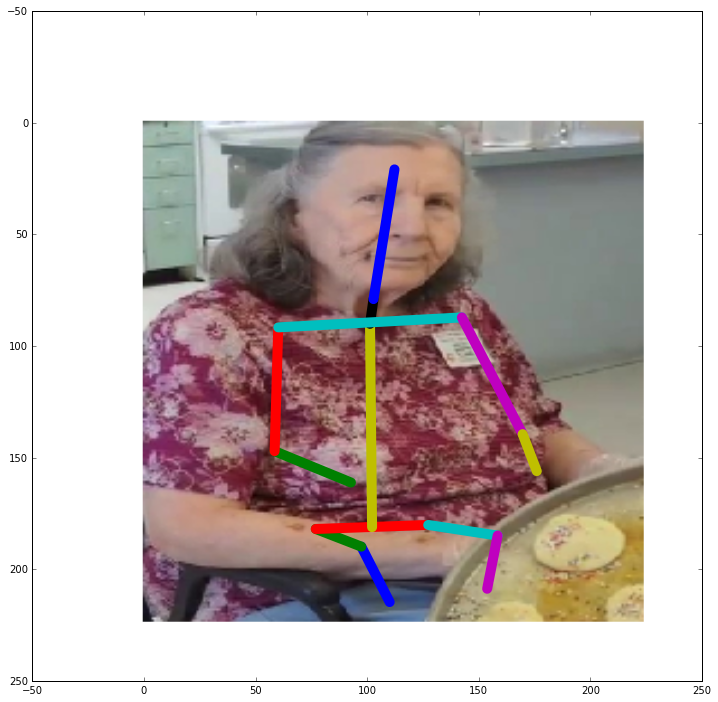

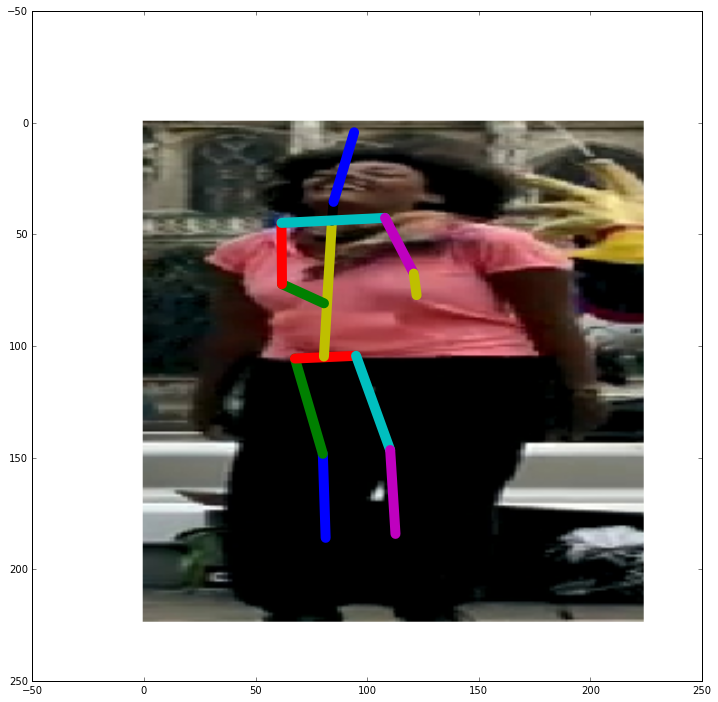

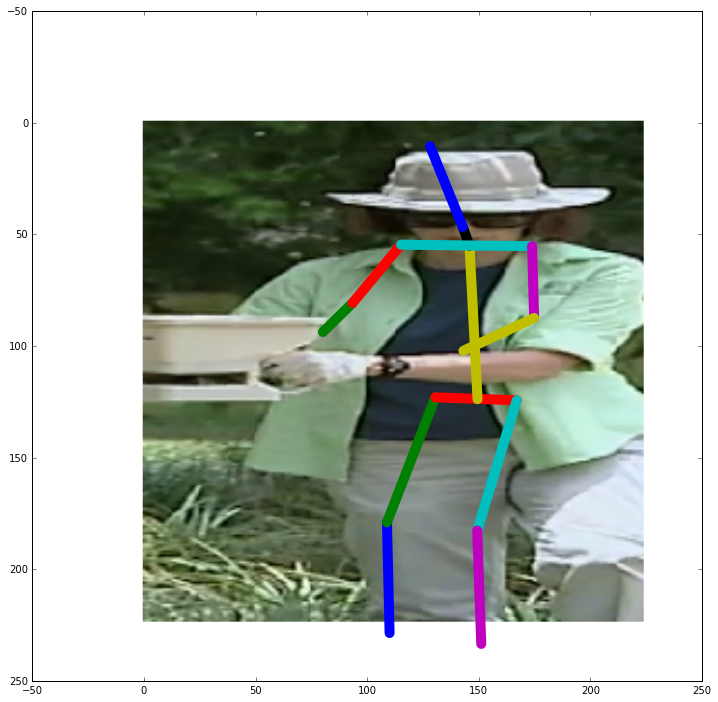

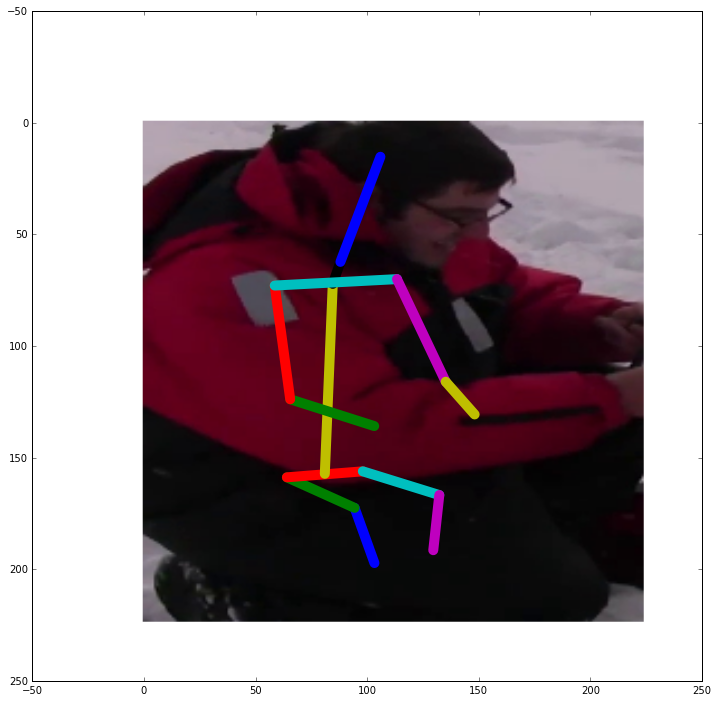

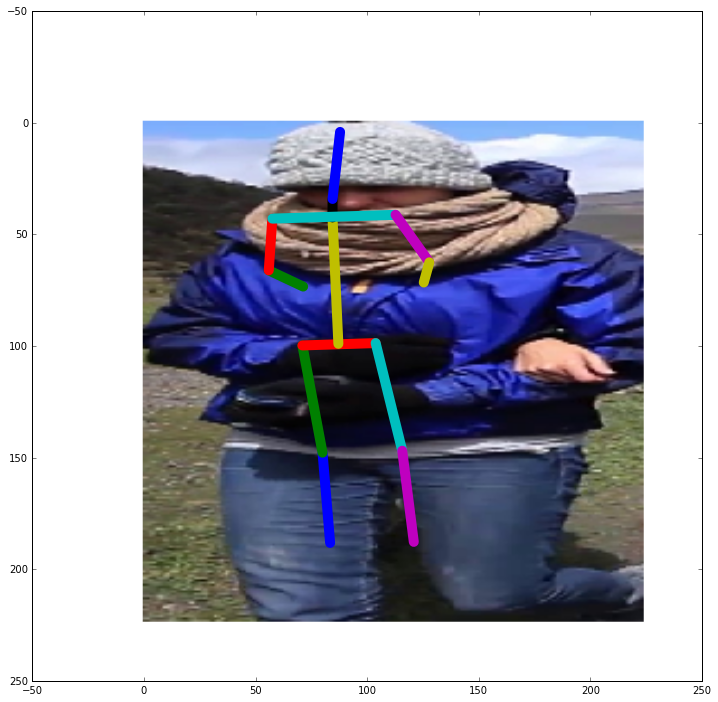

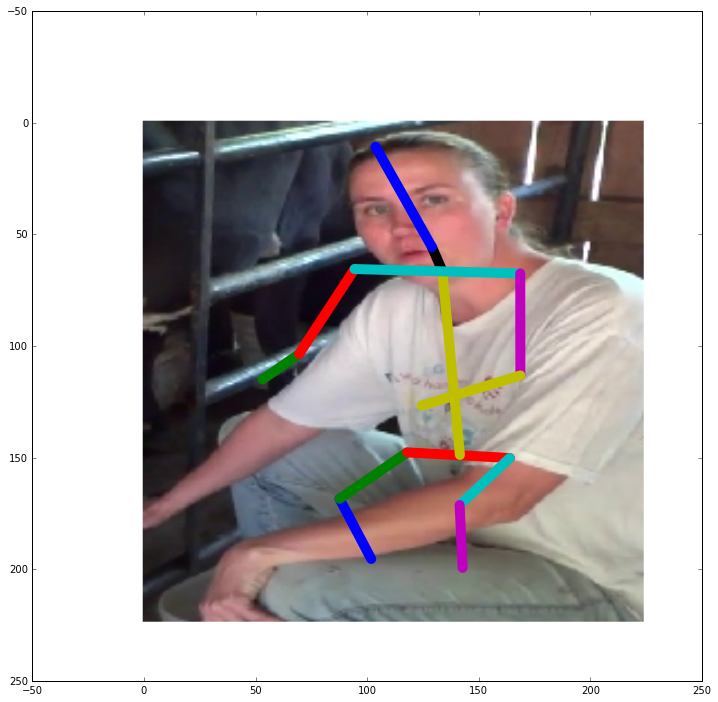

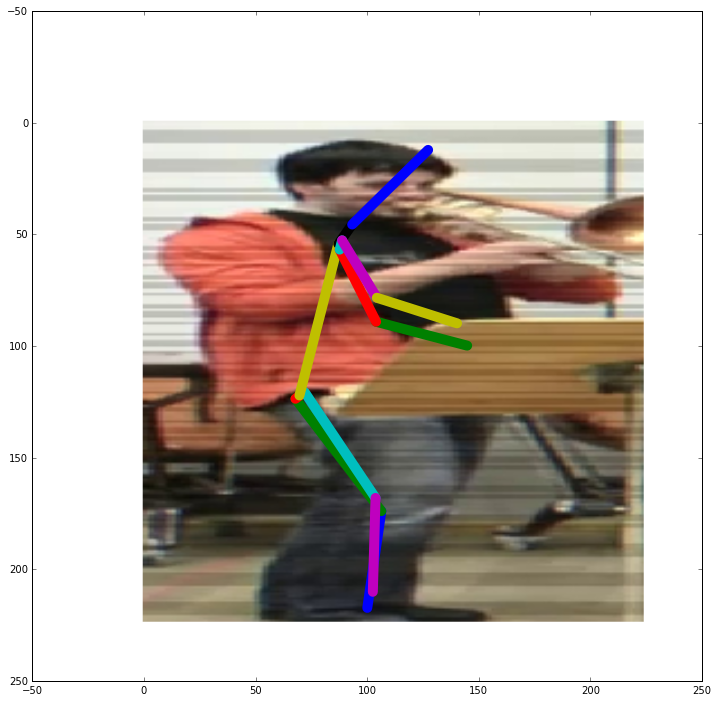

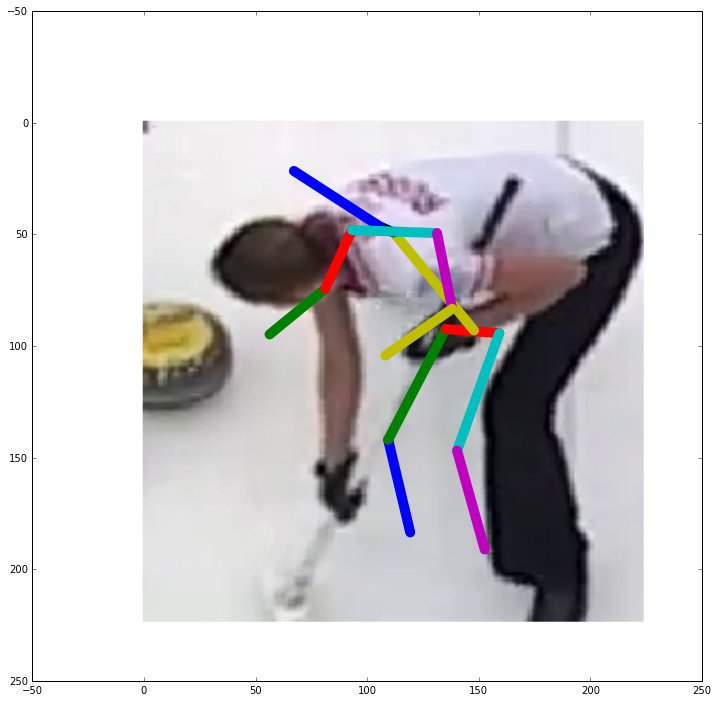

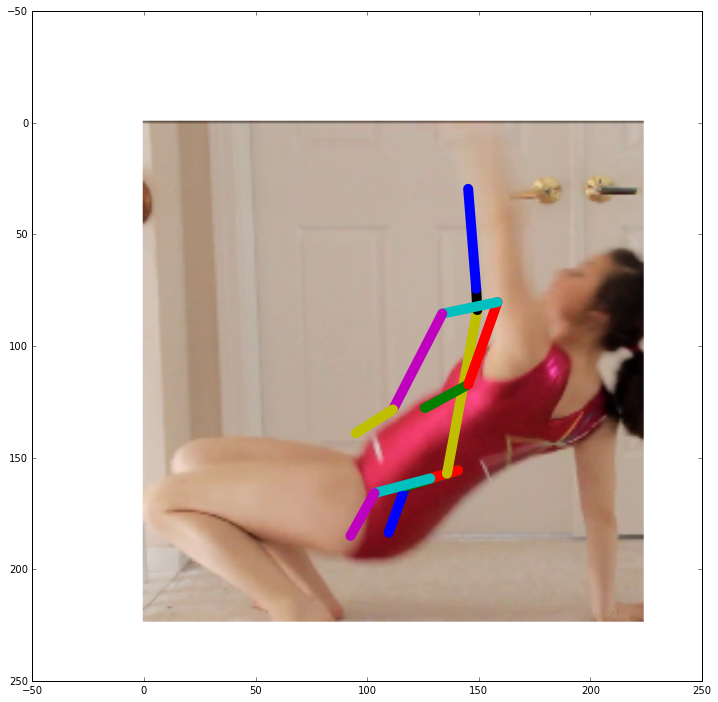

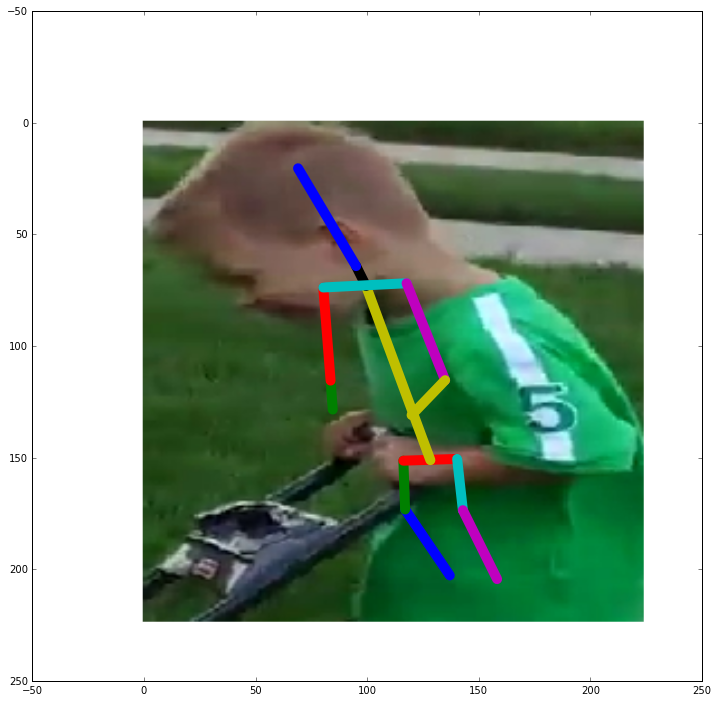

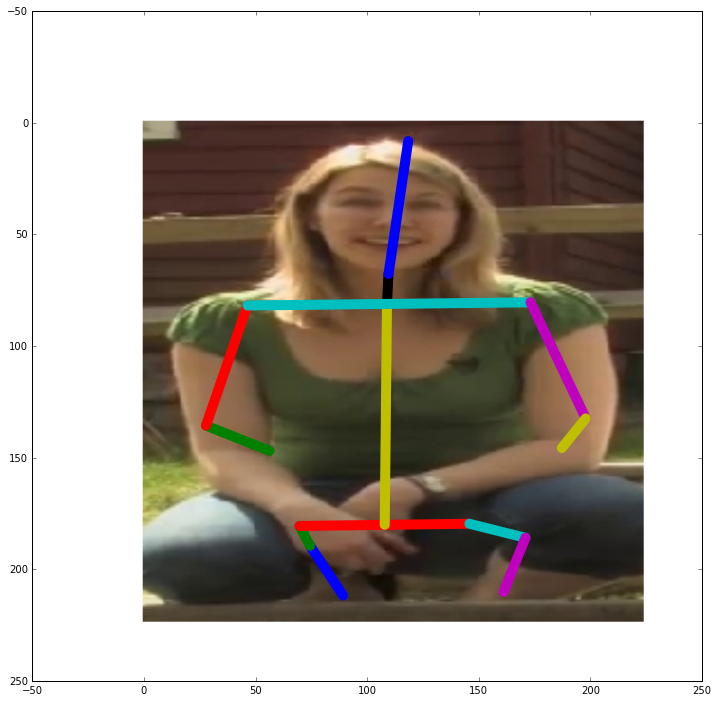

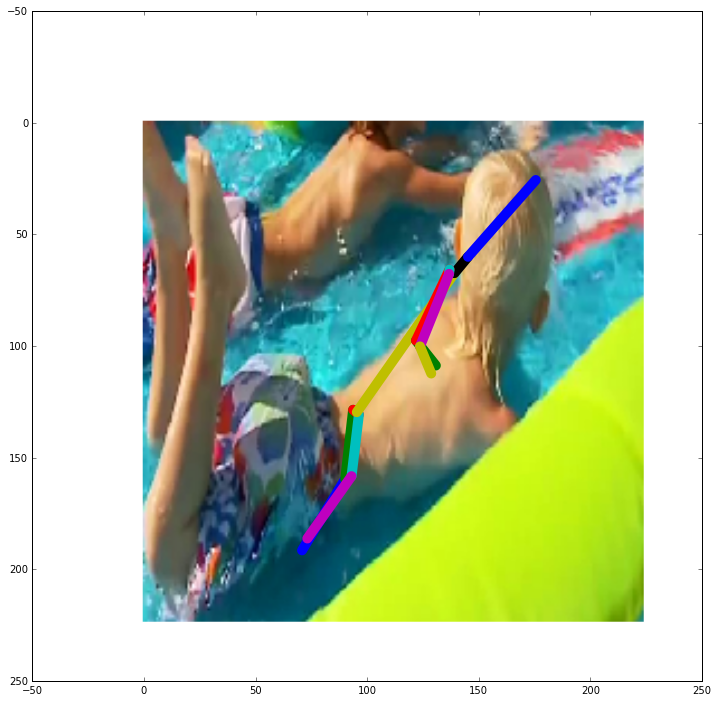

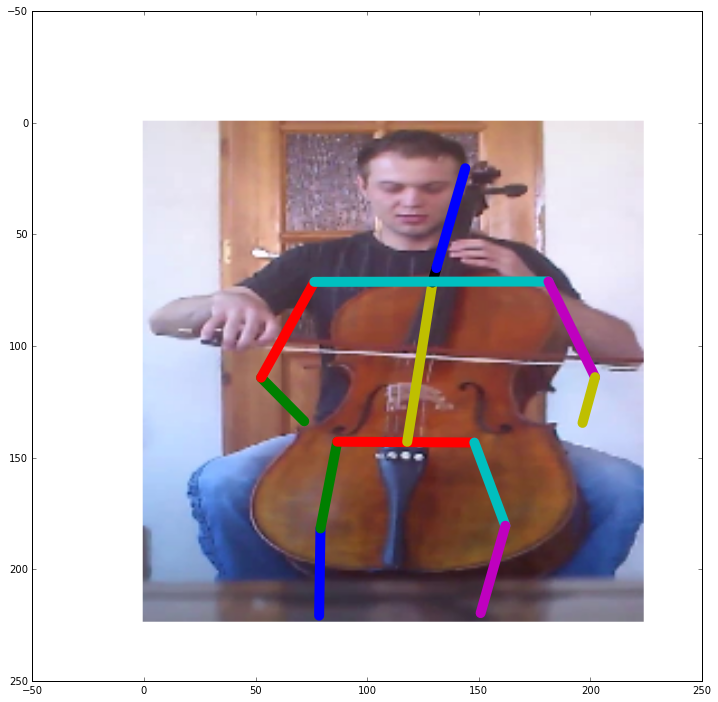

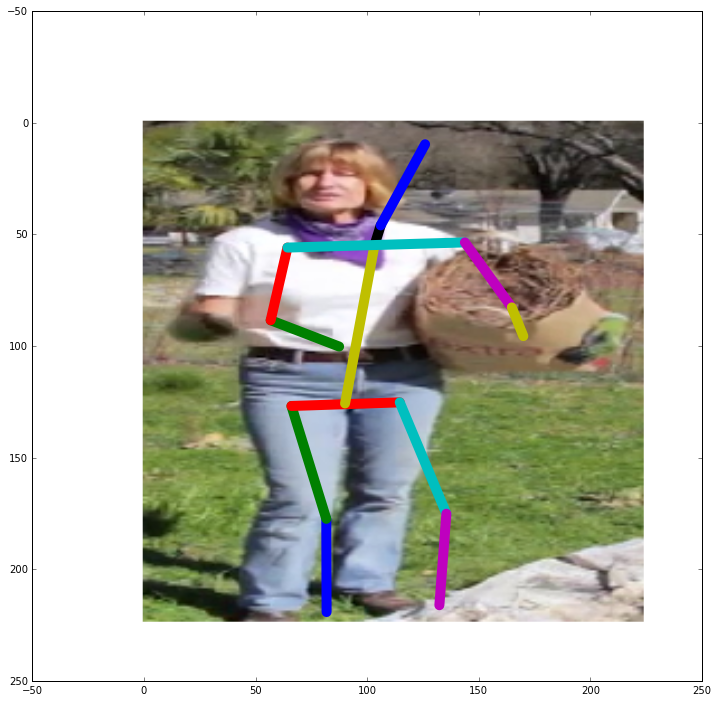

In [15]:
batchX, batchY = reader_val.sample()
pred = network.predict(batchX)

def draw_stickfig(joints):
    width = 10
    for i in range(5):
        plt.plot([joints[i,0], joints[i+1,0]], [joints[i,1], joints[i+1,1]], "-", 
                     linewidth=width, solid_capstyle="round")
    for i in range(6,9):
        plt.plot([joints[i,0], joints[i+1,0]], [joints[i,1], joints[i+1,1]], "-",
                linewidth=width, solid_capstyle="round")
        
    for i in range(10,12):
        plt.plot([joints[i,0], joints[i+1,0]], [joints[i,1], joints[i+1,1]], "-",
                linewidth=width, solid_capstyle="round")
        
    for i in range(12,15):
        plt.plot([joints[i,0], joints[i+1,0]], [joints[i,1], joints[i+1,1]], "-",
                linewidth=width, solid_capstyle="round")

for ind in range(batchX.shape[0]):
    img = batchX[ind,::]
    label = batchY[ind,::]
    jpred = np.array([pred[ind][i,:] for i in range(16)])
    
    plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img.astype(np.uint8))
    
    draw_stickfig(jpred)
    
    plt.show()

In [4]:
from collections import defaultdict as dd
from src.classify_single import batch_predict

#batchX, batchY = reader_val.sample()
#pred = network.predict(batchX)
all_pred, all_gt = batch_predict(network, reader_val, batch_size=25)

In [5]:
def calc_pcp(pred, gt, threshold=0.5):
    assert pred.shape[0] == gt.shape[0]
    mapping = {'head':[8,9], 'body':[6,7], 'shoulders':[12,13], 'hips':[2,3], 'neck':[7,8],
               'uarm1':[11,12], 'larm1':[10,11], 'uleg1':[1,2], 'lleg1':[0,1],
               'uarm2':[13,14], 'larm2':[14,15], 'uleg2':[3,4], 'lleg2':[4,5]}
    pcp = dd(float)
    N = pred.shape[0]
    for i in range(N):
        for part in mapping:
            points = gt[i][mapping[part]]
            max_dist = np.linalg.norm(points[0] - points[1]) * threshold
            p0_corr = np.linalg.norm(gt[i][mapping[part][0]] - pred[i][mapping[part][0]]) < max_dist
            p1_corr = np.linalg.norm(gt[i][mapping[part][1]] - pred[i][mapping[part][1]]) < max_dist
            if p0_corr and p1_corr:
                pcp[part] += 1
    result = {}
    for part in pcp:
        if part[-1].isdigit():
            result[part[:-1]] = (pcp[part[:-1]+'1'] + pcp[part[:-1]+'2']) / 2.0
        else:
            result[part] = pcp[part]
    
    for part in result:
        print '%s : %f' % (part, result[part]/float(N))
    print 'Total : %f' % (np.mean(pcp.values()) / float(N))
    

print calc_pcp(all_pred, all_gt)

body : 0.604407
head : 0.431525
neck : 0.036949
shoulders : 0.468475
uarm : 0.137627
lleg : 0.116949
hips : 0.206441
uleg : 0.159492
larm : 0.047119
Total : 0.205398
None


In [6]:
def calc_pckh(pred, gt, threshold=0.5):
    assert pred.shape[0] == gt.shape[0]
    mapping= {'rankle':0,'rknee':1,'rhip':2,'lhip':3,'lknee':4,'lankle':5,'pelvis':6,'thorax':7,'upperneck':8,
               'headtop':9, 'rwrist':10,'relbow':11,'rshoulder':12,'lshoulder':13,'lelbow':14,'lwrist':15}

    pckh = dd(float)
    N = pred.shape[0]
    for i in range(N):
        max_dist = np.linalg.norm(gt[i][mapping['headtop']] - gt[i][mapping['upperneck']]) * threshold
        for part in mapping:
            dist = np.linalg.norm(gt[i][mapping[part]] - pred[i][mapping[part]])
            corr = dist < max_dist
            if corr:
                pckh[part] += 1

    result = {}
    for part in pckh:
        if (part[0] == 'l' or part[0] == 'r'):
            result[part[1:]] = (pckh['l'+part[1:]] + pckh['r'+part[1:]]) / 2.0
        else:
            result[part] = pckh[part]
        
    for part in result:
        print '%s : %f' % (part, result[part]/float(N))
    print 'Total : %f' % (np.mean(pckh.values()) / float(N))


print calc_pckh(all_pred, all_gt)

headtop : 0.520000
hip : 0.317288
shoulder : 0.405763
ankle : 0.159661
wrist : 0.167627
pelvis : 0.401017
elbow : 0.225424
knee : 0.212373
upperneck : 0.677966
thorax : 0.668814
Total : 0.327754
None
